# Geometric Multigrid


<IPython.core.display.Javascript object>


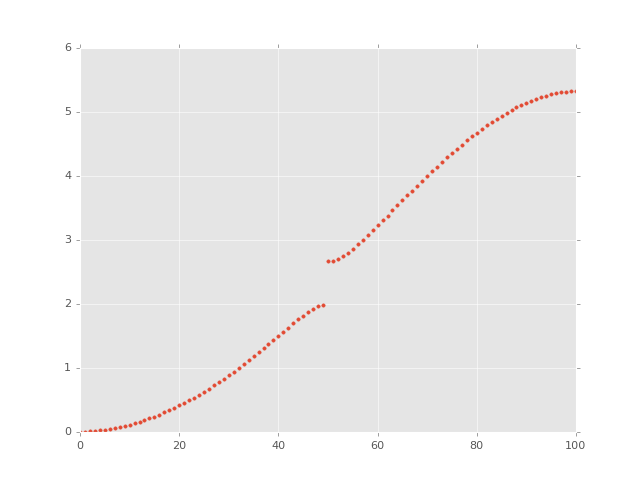

[ 0.00094862  0.00379424  0.0085362   0.01517334] [ 5.3080923   5.3191215   5.32701259  5.33175249]
cond 5620.55452084


In [19]:
%matplotlib notebook
import numpy

m = 101

# I rebuilt this to not be based upon B-splines

# phi_i = 1 - 4 (x-xi)^2/2h^2,              xi-1 < x < xi+1  (odd index)
# phi_i = 1 + 3 (x-xi)/2h + 2(x-xi)^2/2h^2, xi-2 < x < xi
#         1 - 3 (x-xi)/2h + 2(x-xi)^2/2h^2, xi   < x < xi+2  (even index)

# Solving u'' = 0
# Set u = sum(u_i phi_i)
# Want (u'', phi_i) = 0
# Integration By Parts (u', phi_i') = 0
# u' = sum( u_1 phi_i')

# (phi_i', phi_i') = 8/3h    (odd index)
# (phi_i', phi_i') = 7/3h    (even index)
# (phi_i', phi_i-1') = -4/3h
# (phi_i', phi_i+1') = -4/3h
# (phi_i', phi_i+2') = 1/6h  (even index)

# A = [ 8/3 -4/3 
#      -4/3  7/3 -4/3  1/6
#           -4/3  8/3 -4/3
#            1/6 -4/3  7/3 -4/3  1/6
#                     -4/3  8/3 -4/3
#                           ...  ...  ...
#                               -4/3  8/3 -4/3]

# Inner products could requrie numerical integration with more complex RHS

A = 8/3*numpy.eye(m) - 4/3*numpy.eye(m, m, -1) -4/3*numpy.eye(m, m, 1)
for i in range(int(m/2)):
    A[2*i+1,2*i+1] = 7/3
for i in range(int((m-2)/2)):
    A[2*i+1, 2*i+3] = 1/6
    A[2*i+3, 2*i+1] = 1/6

I = numpy.eye(m)
L, X  = numpy.linalg.eigh(A)

from matplotlib import pyplot
pyplot.style.use('ggplot')
pyplot.figure()
pyplot.plot(L, '.')
pyplot.show()

print(L[:4], L[-4:])
print('cond', L[-1]/L[0])

<IPython.core.display.Javascript object>


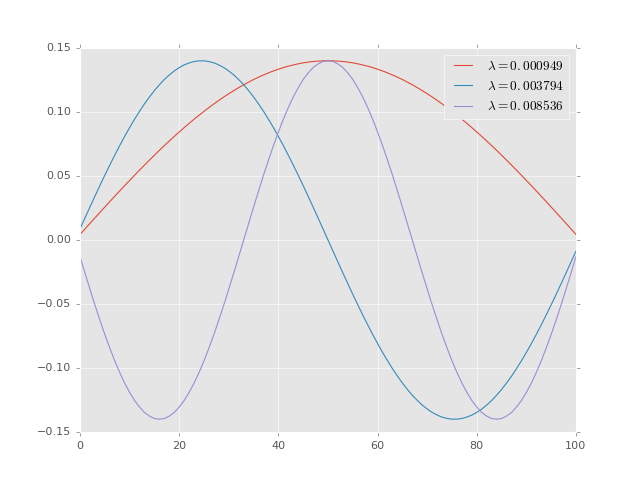

In [3]:
pyplot.figure()
for i in (0,1,2):
    pyplot.plot(X[:,i], label='$\lambda = %f$' % L[i])
pyplot.legend(loc='upper right')
pyplot.show()

<IPython.core.display.Javascript object>


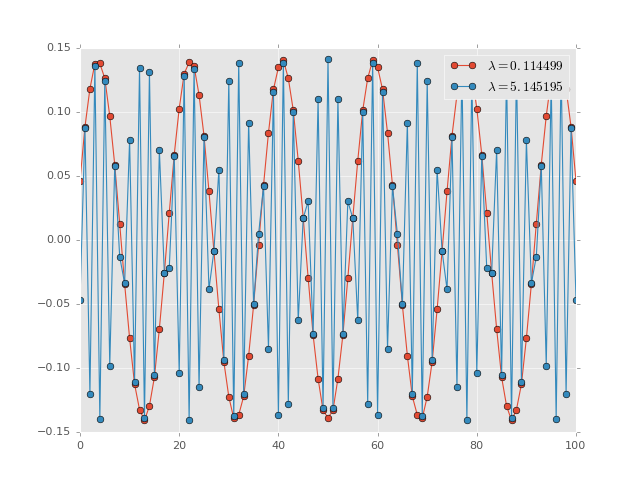

In [4]:
pyplot.figure()
for i in (10,90):
    pyplot.plot(X[:,i], '-o', label='$\lambda = %f$' % L[i])
pyplot.legend(loc='upper right')
pyplot.show()

<IPython.core.display.Javascript object>


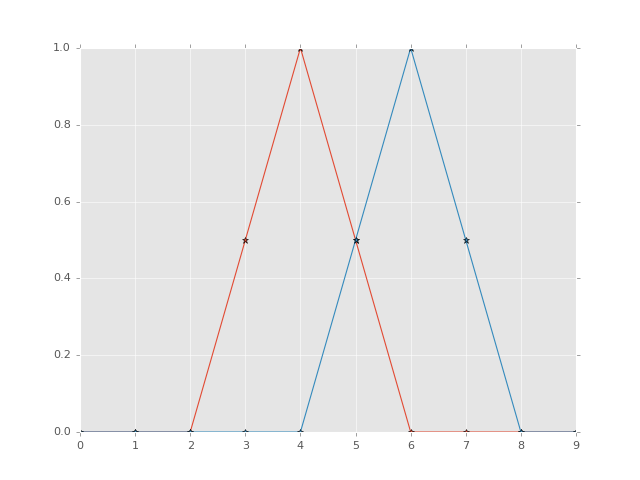

(101, 51)

In [5]:
P = numpy.eye(m) + .5*numpy.eye(m,k=1) + .5*numpy.eye(m,k=-1)
P = P[:,::2]
#P = numpy.eye(m) + 2./3*(numpy.eye(m,k=1)+numpy.eye(m,k=-1)) + \
#    1./3*(numpy.eye(m,k=2)+numpy.eye(m,k=-2))
#P = P[:,::3]

pyplot.figure()
pyplot.plot(P[:10,2:4], '-*')

P.shape

<IPython.core.display.Javascript object>


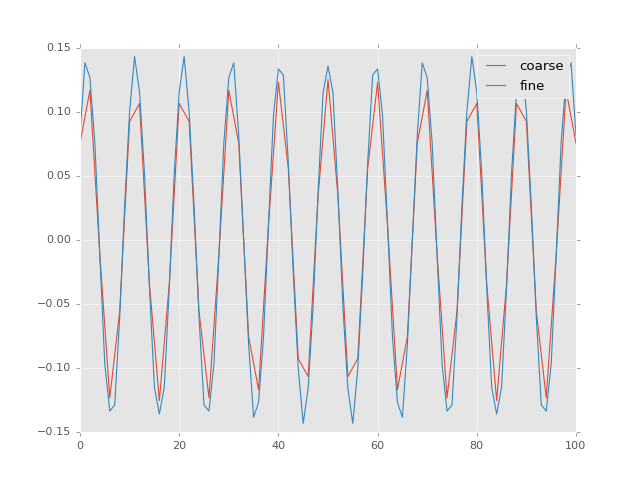

In [6]:
pyplot.figure()
pyplot.plot(1./2*P.dot(P.T.dot(X[:,20])), label='coarse')
pyplot.plot(X[:,20], label='fine')
pyplot.legend(loc='upper right')

(51, 51)


<IPython.core.display.Javascript object>


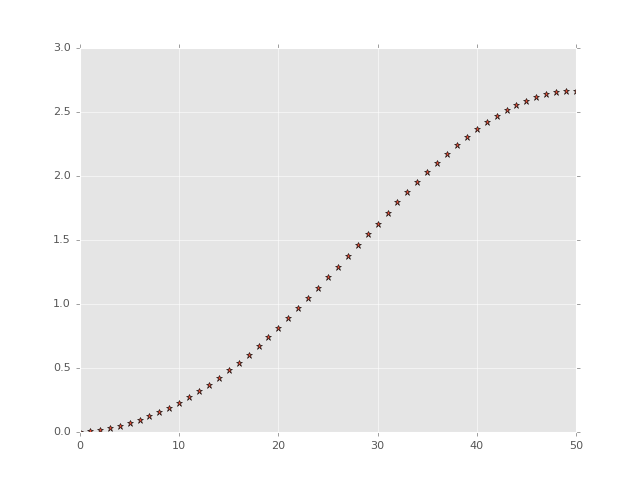

In [7]:
Ac = P.T.dot(A.dot(P))
print(Ac.shape)

Lc, Xc = numpy.linalg.eigh(Ac)
pyplot.figure()
pyplot.plot(Lc, '*')

<IPython.core.display.Javascript object>


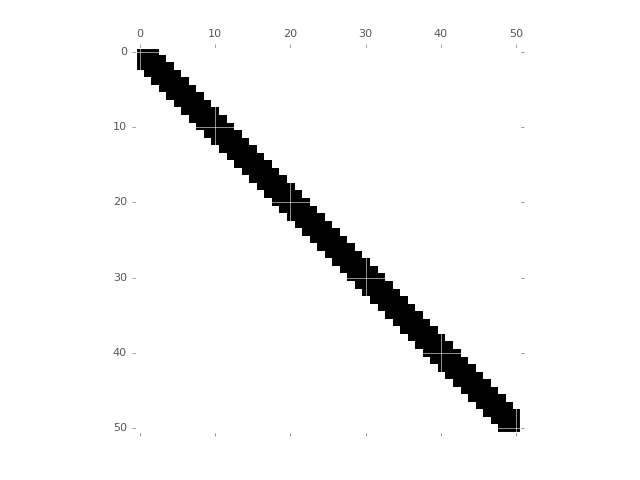

array([[ 1.91666667, -0.70833333,  0.04166667,  0.        ,  0.        ],
       [-0.70833333,  1.25      , -0.66666667,  0.04166667,  0.        ],
       [ 0.04166667, -0.66666667,  1.25      , -0.66666667,  0.04166667],
       [ 0.        ,  0.04166667, -0.66666667,  1.25      , -0.66666667],
       [ 0.        ,  0.        ,  0.04166667, -0.66666667,  1.25      ]])

In [8]:
pyplot.figure()
pyplot.spy(Ac)
Ac[:5,:5]

1.98116491282e-14


<IPython.core.display.Javascript object>


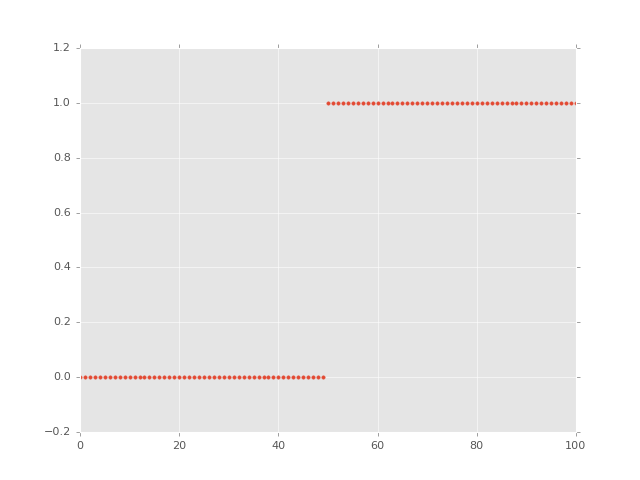

In [9]:
# Consider the A-orthogonal projector into the range of P
Sc = P.dot(numpy.linalg.inv(Ac)).dot(P.T).dot(A)
Ls, Xs = numpy.linalg.eig(Sc)
print(max(abs(Ls.imag)))
Ls = Ls.real
idx = Ls.argsort()
Ls = Ls[idx]; Xs = Xs[:,idx]

pyplot.figure()
pyplot.plot(Ls, '.')

<IPython.core.display.Javascript object>


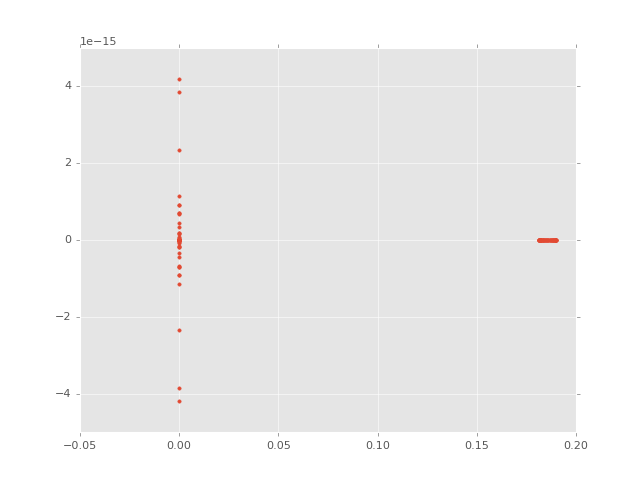

In [21]:
def pcjacobi(A):
    Dinv = numpy.diag(1/A.diagonal())
    return Dinv.dot(A)

# Iteration matrix for a V(1,1) cycle
DinvA = pcjacobi(A)
Lt, Xt = numpy.linalg.eig((I - .67*DinvA).dot(I - Sc).dot(I - .67*DinvA))
pyplot.figure()
pyplot.plot(Lt.real, Lt.imag, '.')

### Choices for linear multigrid
* Smoother
* Interpolation $P$ (coarse basis)
* Restriction ($P^T$, or different for non-symmetric problems)
* Coarse operator (Galerkin $P^T A P$, rediscretization)

## Multigrid as factorization

We can interpret factorization as a particular multigrid or domain decomposition method.

We can partition an SPD matrix as
$$J = \begin{bmatrix} A & B^T \\ B & D \end{bmatrix}$$
and define the preconditioner by the factorization
$$      M = \begin{bmatrix} I & \\ B A^{-1} & I \end{bmatrix}
      \begin{bmatrix} A &  \\ & S \end{bmatrix}
      \begin{bmatrix} I & A^{-1}B^T \\  & I \end{bmatrix}
$$
where $S = D - B A^{-1} B^T$.  $M$ has an inverse
$$      M^{-1} =
      \begin{bmatrix} I & -A^{-1}B^T \\  & I \end{bmatrix}
      \begin{bmatrix} A^{-1} &  \\ & S^{-1} \end{bmatrix}
      \begin{bmatrix} I & \\ -B A^{-1} & I \end{bmatrix} .
$$
Define the interpolation
$$ P_f = \begin{bmatrix} I \\ 0 \end{bmatrix}, \quad P_c = \begin{bmatrix} -A^{-1} B^T \\ I \end{bmatrix} $$ and rewrite as
$$ M^{-1} = [P_f\  P_c] \begin{bmatrix} A^{-1} P_f^T \\ S^{-1} P_c^T \end{bmatrix} = P_f A^{-1} P_f^T + P_c S^{-1} P_c^T.$$
The iteration matrix is thus
$$ I - M^{-1} J = I - P_f A^{-1} P_f^T J - P_c S^{-1} P_c^T J .$$

<IPython.core.display.Javascript object>


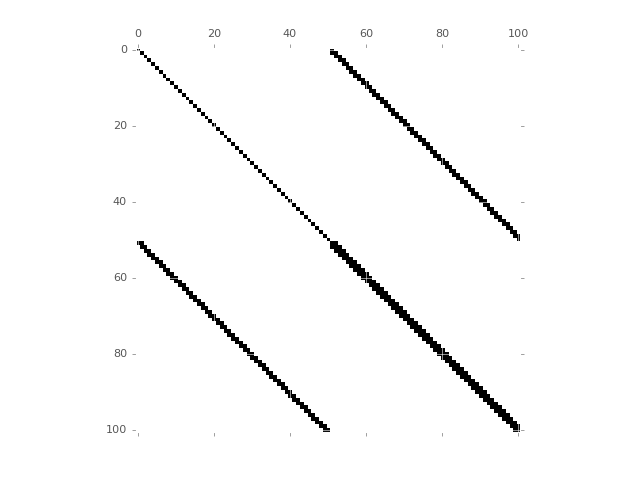

In [11]:
idx = numpy.concatenate((numpy.arange(0,m,2), numpy.arange(1,m,2)))
J = A[:,idx][idx,:]
pyplot.figure()
pyplot.spy(J)

<IPython.core.display.Javascript object>


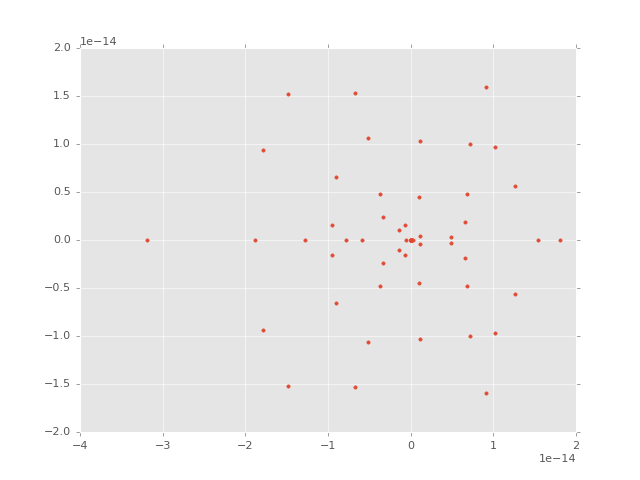

In [25]:
mf = m // 2 + 1
Pf = numpy.concatenate((numpy.eye(mf), numpy.zeros((m-mf, mf))))
Jf = Pf.T.dot(J.dot(Pf))
Pc = numpy.concatenate((-numpy.linalg.inv(Jf).dot(J[:mf,mf:]), numpy.eye(m-mf)))
Jc = Pc.T.dot(J.dot(Pc))

DinvJ = pcjacobi(J)
Mf = Pf.dot(numpy.linalg.inv(Jf)).dot(Pf.T)
Mc = Pc.dot(numpy.linalg.inv(Jc)).dot(Pc.T)
T = I - (Mf + Mc).dot(J)
T = (I - Mf.dot(J)).dot(I - Mc.dot(J))
#T = (I - .67*DinvJ).dot(I - Mc.dot(J))
#T = T.dot(T)
#T = (I - .67*DinvJ).dot(I - .67*DinvJ).dot(I - Mc.dot(J)).dot(I - .67*DinvJ)
#T = I - .67*J - Mc.dot(J)
Lt, Xt = numpy.linalg.eig(T)
pyplot.figure()
pyplot.plot(Lt.real, Lt.imag, '.')

<IPython.core.display.Javascript object>


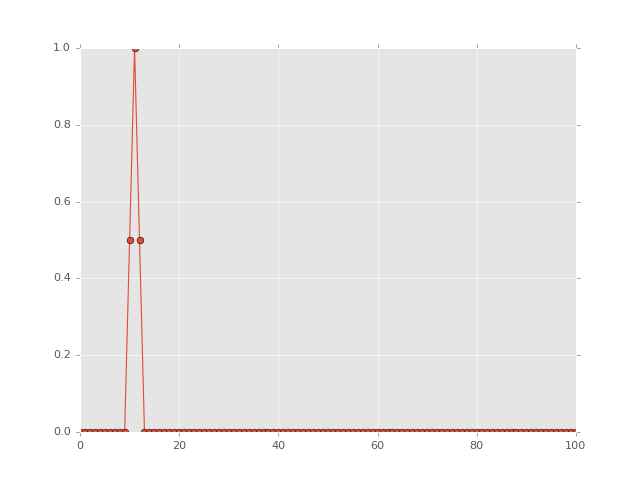

In [26]:
# Invert the permutation
idxinv = numpy.zeros(m, dtype=int)
idxinv[idx] = numpy.arange(m)

# Plot the coarse basis function in the original ordering
pyplot.figure()
pyplot.plot(Pc[:,5][idxinv], '-o')

In [14]:
M = numpy.array([[1,2],[2,1]])
numpy.linalg.eigh(M)

(array([-1.,  3.]), array([[-0.70710678,  0.70710678],
        [ 0.70710678,  0.70710678]]))

# Algebraic Multigrid

Factorization as a multigrid (or domain decomposition) method incurs significant cost in multiple dimensions due to lack of sparsity.  It is not feasible to choose enough coarse basis functions so that coarse basis functions that use minimum energy extensions $-A^{-1} B^T$ (see $P_c$ and the notation above) have sufficiently local support.

Algebraic multigrid methods operate by specifying a coarsening algorithm and degree of sparsity, then attempting to choose good basis functions within those constraints.  Classical AMG chooses coarse points much like the factorization methods above, but restricts the support of the basis functions and uses heuristics to weight the contributions in order to approximate selected functions (like the constant).  Smoothed aggregation chooses aggregates and *tentative* basis functions $T$ on the aggregates (to reproduce the constants or other functions exactly), then uses Jacobi relaxation to compute an interpolation $P = (I - \omega D^{-1} J)T$ which is smoother than $T$, but with correspondingly larger support.

Let's examine this construction of basis functions for the 1D Laplacian.

<IPython.core.display.Javascript object>


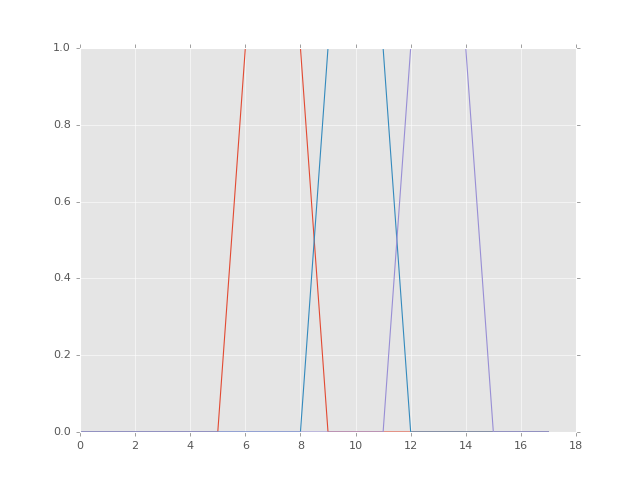

In [27]:
cfactor = 3
agg = numpy.arange(m) // cfactor
mc = max(agg)+1
T = numpy.zeros((m,mc))
T[numpy.arange(m), agg] = 1

pyplot.figure()
pyplot.plot(T[:6*cfactor,2:5])

<IPython.core.display.Javascript object>


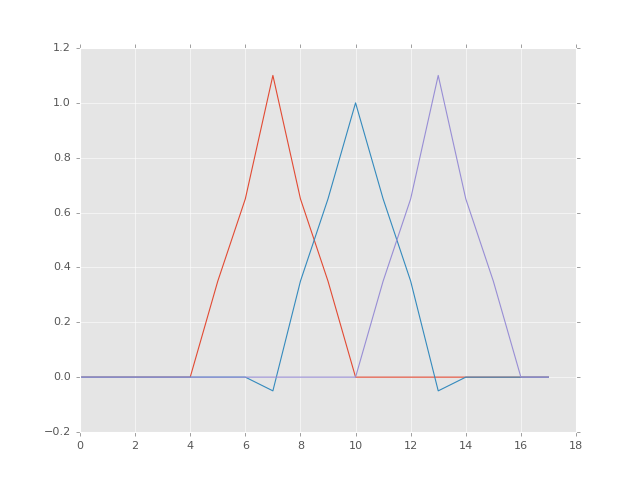

<IPython.core.display.Javascript object>


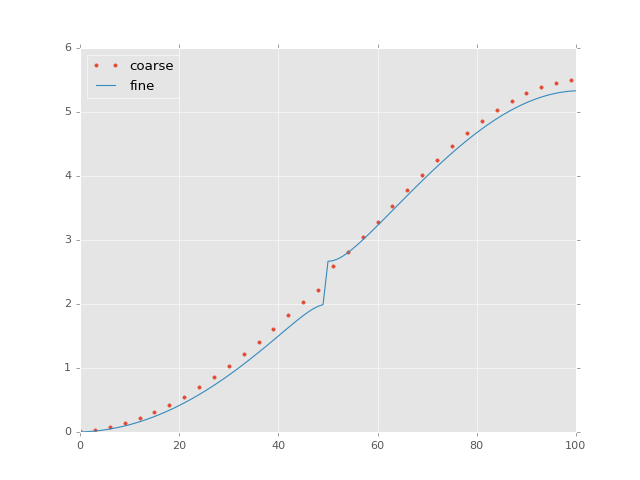

In [28]:
P = (I - .7*DinvA).dot(T)

pyplot.figure()
pyplot.plot(P[:6*cfactor,2:5])

Ac = P.T.dot(A).dot(P)
pyplot.figure()
pyplot.plot(numpy.arange(m,step=cfactor),numpy.linalg.eigh(Ac)[0]*3, '.', label='coarse')
pyplot.plot(numpy.arange(m),numpy.linalg.eigh(A)[0], '-', label='fine')
pyplot.legend(loc='upper left')

<IPython.core.display.Javascript object>


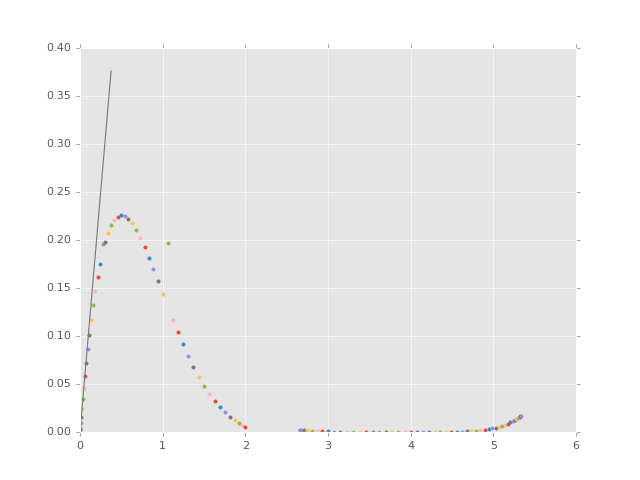

In [29]:
L, X = numpy.linalg.eigh(A)
pyplot.figure()
for i in range(m):
    x = X[:,i]
    pyplot.plot(x.T.dot(A).dot(x), x.T.dot(P.dot(Ac).dot(P.T.dot(x)))/cfactor**2, '.')
pyplot.plot(L[:20], L[:20], '-')

* What if we use a more rapid coarsening factor?
* What if we change the damping factor in the Jacobi smoother?
* What if we do multiple smoothing iterations?